# SASRSA and Q-Learning


### Libraries

In [ ]:
# Just to see the performance and the time taken by the code
import time

# For deepcopy
import copy

# For testing (brute force hyperparameter search takes a long time)
import random

# For encoding/decoding configuration as strings
import hashlib

# To create a grid of hyper-parameters
from itertools import product

# Just to see the hyperparameter search results
import pandas as pd

# For extracting variables from configuration string
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Environment description

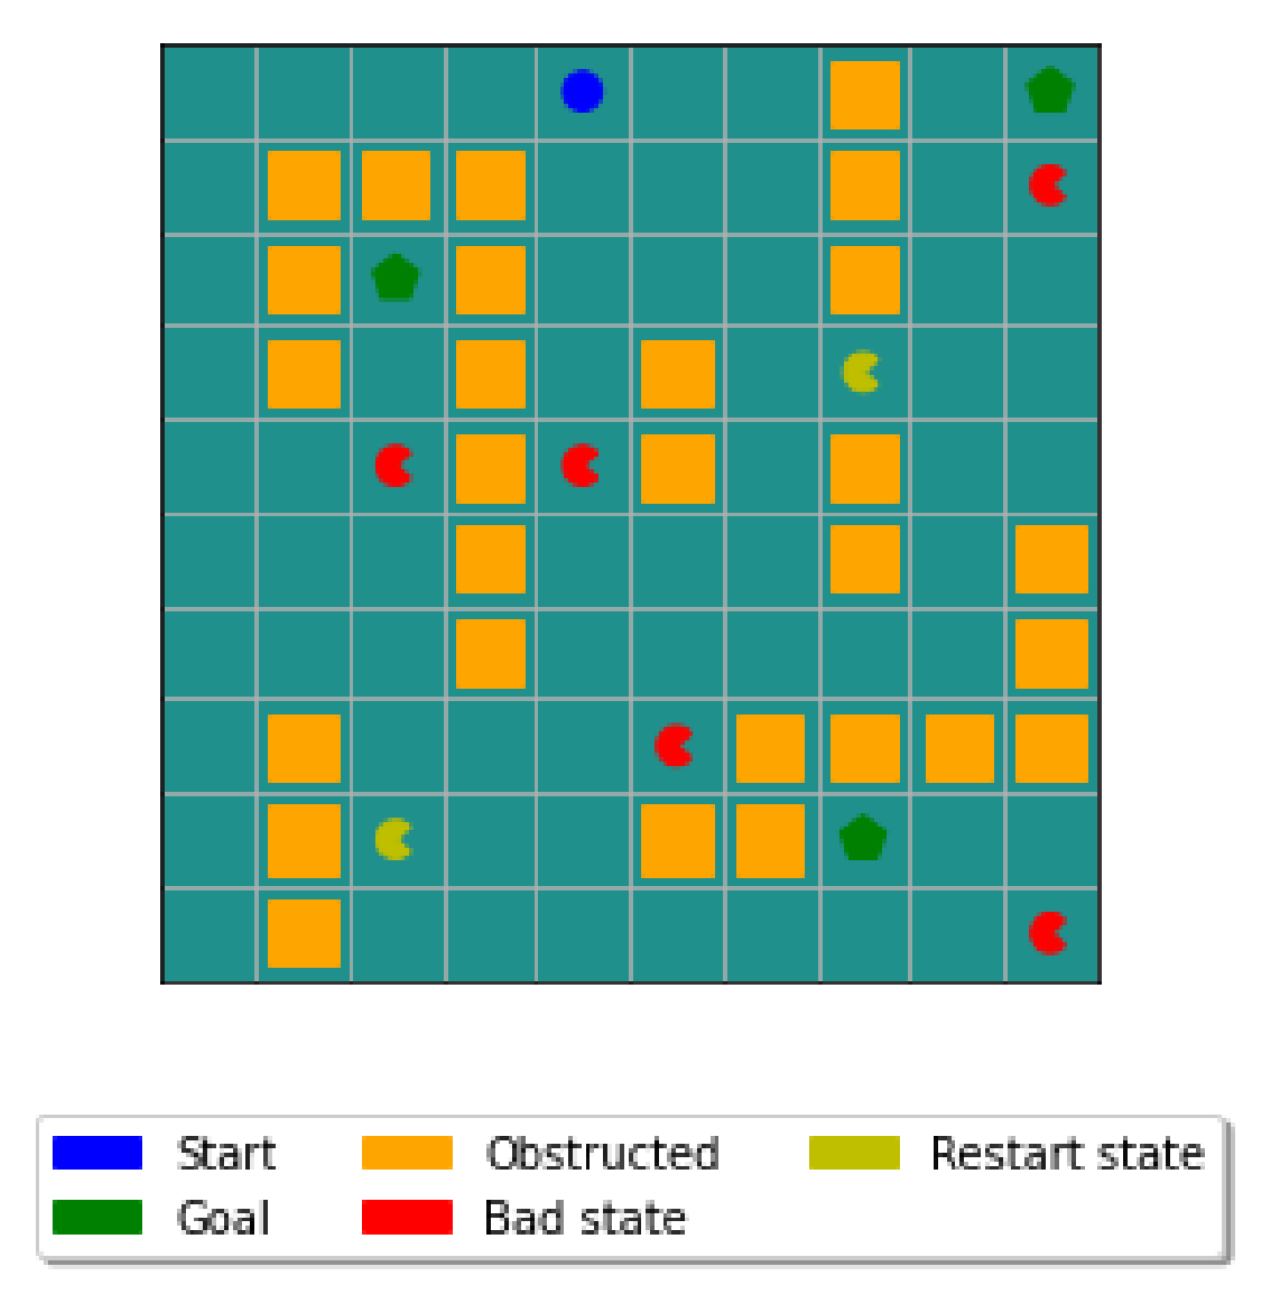

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

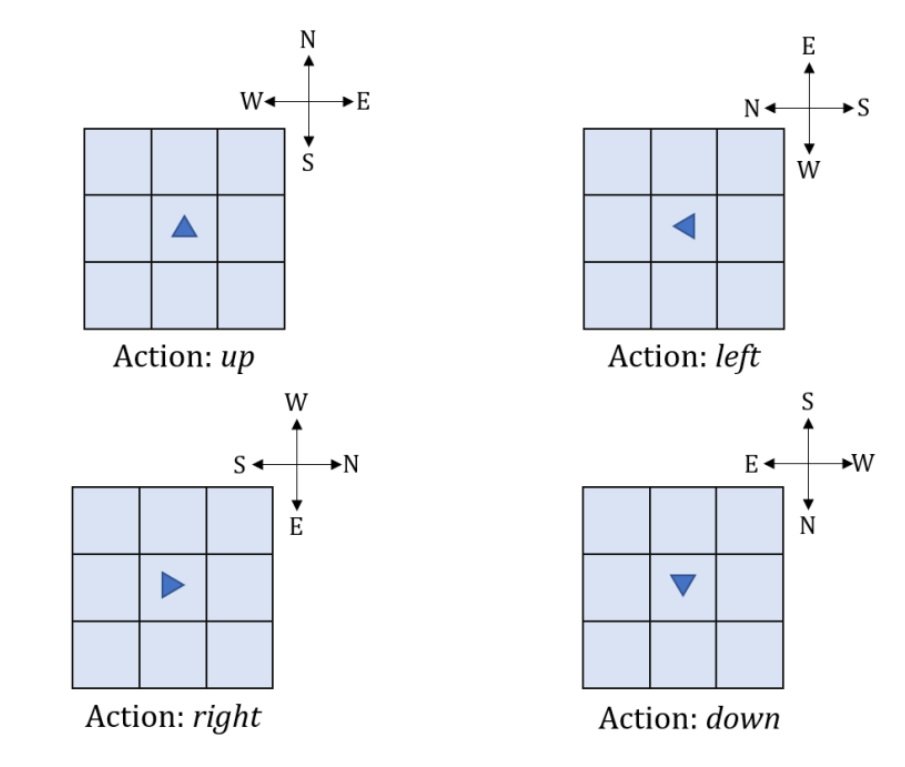

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

In [ ]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward

    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[3,6]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [ ]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Experiments
- Implement SARSA and Q-Learning.

- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.

- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

- Trying following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

## Configurations [64 Marks]

There are total 32 configurations (16 each for SARSA and Q-Learning), each of which carry 2 marks.

**Defining SARSA and Q-Learning's Parameters and Hyperparameters**

In [ ]:
np.random.seed(42)

hyperparameters = {
    'alphas': [0.001, 0.01, 0.1, 1.0],            # Learning Rate
    'gammas': [0.7, 0.8, 0.9, 1.0],               # Discount Factor
    'epsilon_values': [0.001, 0.01, 0.05, 0.1],   # For Eps-Greedy
    'temperature_values': [0.01, 0.1, 1, 2],      # For Softmax
}

sarsa_parameters = {
    'wind' : [True, False],
    'start_state': [(0, 4), (3, 6)],
    'p_values': [1.0],
    'strategies': ['epsilon_greedy', 'softmax'],
}

q_learning_parameters = {
    'wind' : [False],
    'start_state': [(0, 4), (3, 6)],
    'p_values': [1.0, 0.7],
    'strategies': ['epsilon_greedy', 'softmax'],
}

no_of_episodes = 200

# Maximum no. of steps per episode. Also a stopping criteria. Increasing this
# will increase the hyperparameter search time around by the same factor.
max_steps_per_episode = 400

**Defining All SARSA's Configurations**

In [ ]:
# Create a list of all combinations of hyperparameters
sarsa_all_configurations = []

for alpha in hyperparameters['alphas'] :
    for gamma in hyperparameters['gammas'] :
        for wind in sarsa_parameters['wind'] :
            for ss in sarsa_parameters['start_state'] :
                for p in sarsa_parameters['p_values'] :
                    for strategy in sarsa_parameters['strategies'] :
                        if(strategy == 'epsilon_greedy') :
                            for epsilon in hyperparameters['epsilon_values'] :
                                sarsa_all_configurations.append(
                                    (wind, ss, p, strategy, \
                                     alpha, gamma, epsilon)
                                )
                        else :
                            for temperature in hyperparameters['temperature_values'] :
                                sarsa_all_configurations.append(
                                    (wind, ss, p, strategy, \
                                     alpha, gamma, temperature)
                                )

assert len(sarsa_all_configurations) == 512

**Defining All Q-Learning's Configurations**

In [ ]:
# Create a list of all combinations of hyperparameters
q_learning_all_configurations = []

for alpha in hyperparameters['alphas'] :
    for gamma in hyperparameters['gammas'] :
        for wind in q_learning_parameters['wind'] :
            for ss in q_learning_parameters['start_state'] :
                for p in q_learning_parameters['p_values'] :
                    for strategy in q_learning_parameters['strategies'] :
                        if(strategy == 'epsilon_greedy') :
                            for epsilon in hyperparameters['epsilon_values'] :
                                q_learning_all_configurations.append(
                                    (wind, ss, p, strategy, \
                                     alpha, gamma, epsilon)
                                )
                        else :
                            for temperature in hyperparameters['temperature_values'] :
                                q_learning_all_configurations.append(
                                    (wind, ss, p, strategy, \
                                     alpha, gamma, temperature)
                                )

assert len(q_learning_all_configurations) == 512

## **For Testing**

**Sampling only a few configurations for SARSA and Q-Learning**


- This is just for testing. The final code will use all the
configurations.
- Since using all the configurations takes a long time, **I'm randomly sampling 50 to 100 configurations and testing whether the code works or not.**


In [ ]:
'''
This is just for testing. The final code will use all the
configurations. Since this takes a long time, I'm randomly sampling
50 to 100 configurations and testing whether the code works or not.
'''

# samples = 10

# Randomly select 100 to 1000 configurations out of 512
# sarsa_cfgs       = random.sample(sarsa_all_configurations, samples)
# q_learning_cfgs  = random.sample(q_learning_all_configurations, samples)

sarsa_cfg = sarsa_all_configurations
q_learning_cfgs = q_learning_all_configurations

# assert len(sarsa_cfgs) == samples
# assert len(q_learning_cfgs) == samples

In [ ]:
# env.step(current_state, action) returns [next_state, reward]
# env.step(s_t, a_t) ==> [s_t+1, r_t+1]

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

### **NOTE : I'M NOT USING THIS TEMPLATE**

- **REASON** : <br>
Writing each and every configuration out of the 16 is quite cumbersome. <br> So, I'm using a hyperparameter grid and I'm **iterating through it**.
- **Appropriate debug information is added**
- **Random state seed has been set**

~~ Configuration id << insert id>> ~~

<br>

~~ Configuration Parameters ~~

~~ Learning algorithm = ~~

~~ Wind = ~~

~~ Start State = ~~

~~ Value of $p$ = ~~

~~ Exploration strategy = ~~


## **Helper Functions**

In [ ]:
# Helper functions

def greedy(Q, state):
    return np.argmax(Q[state])

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(Q[state]))
    else:
        return np.argmax(Q[state])

def softmax(Q, state, temperature):
    logits = Q[state] / temperature
    probabilities = np.exp(logits - np.max(logits))
    probabilities /= np.sum(probabilities)
    return np.random.choice(len(Q[state]), p=probabilities)

def create_env(start_state, wind) :
  # size of the grid
  num_cols = 10
  num_rows = 10

  # coordinates of the cells representing obstruction
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                          [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                          [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                          [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

  # lsit of bad states
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

  # list of restart states
  restart_states = np.array([[3,7],[8,2]])

  # starting position
  start_state = np.array([start_state])

  # list of goal states i.e. terminal states
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create the environment's model
  gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states,
                wind = wind)

  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)

  gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)
  env = gw.create_gridworld()

  return env

def encode(config_key):
    config_str = str(config_key)
    hash_object = hashlib.sha256(config_str.encode())
    hash_hex = hash_object.hexdigest()
    unique_name = hash_hex[:8]  # Truncate to 8 characters
    return unique_name

def calc_state_visit_count(Q, num_states) :
  # Calculate state visit counts based on Q-values
  state_visit_counts = np.zeros((num_rows, num_cols))

  for state in range(num_states):
      visited_count = np.sum(Q[state] > 0)
      row, col = seq_to_col_row(state, num_cols)[0]
      state_visit_counts[row, col] = visited_count

  return state_visit_counts

def run_episodes(env, Q, num_steps=100):
    '''
    Run some episodes to test the policy
    '''
    tot_rew = []
    tot_steps = []
    state = env.reset()

    for _ in range(num_steps):
        done = False
        game_rew = 0
        steps = 0

        while not done:
            if (state in env.goal_states_seq or steps >= max_steps_per_episode):
                done = True

            # select a greedy action
            next_state, rew = env.step(state, greedy(Q, state))
            state = next_state
            game_rew += rew
            steps += 1

            if done:
                state = env.reset()
                tot_rew.append(game_rew)
                tot_steps.append(steps)

    return (np.mean(tot_rew), np.mean(tot_steps))

# Function to plot reward curves
def plot_reward_curve(train_rewards, num_episodes, config_str):

  x = np.linspace(1, num_episodes, num_episodes)
  train_rewards = train_rewards.flatten()

  assert len(train_rewards) == len(x) == num_episodes

  plt.figure()
  sns.scatterplot(x=x, y=train_rewards)
  ax = sns.lineplot(x=x, y=train_rewards)
  ax.set(title='Reward Curve During Training : {}'.format(config_str), \
        xlabel='Episode', ylabel='Reward')

# Function to plot steps per episode
def plot_steps_per_episode(train_steps, num_episodes, config_str):

  x = np.linspace(1, num_episodes, num_episodes)
  assert len(train_steps) == len(x) == num_episodes

  plt.figure()
  sns.scatterplot(x=x, y=train_steps)
  ax = sns.lineplot(x=x, y=train_steps)
  ax.set(title='Number of Steps Curve During Training : {}'.format(config_str), \
        xlabel='Episode', ylabel='Number of Steps')

# Function to plot state visit counts heatmap
def plot_state_visit_counts(state_visit_counts, config_str):

    # print(state_visit_counts.shape, " : \
    #  (number_of_episode, num_states, num_states)")

    assert np.any([np.any(x < 0) for x in state_visit_counts]) == False

    state_visits_across_episodes = np.sum(state_visit_counts, axis=0)

    assert state_visits_across_episodes.shape == (10, 10)

    plt.figure(figsize=(10, 8))

    ax = sns.heatmap(data=state_visits_across_episodes, annot=True, \
                fmt=".0f", cmap='rocket_r')

    ax.set(title='Heatmap of the grid with state visit counts : {}'.format(config_str), \
           xlabel='State', ylabel='State')

def plot_required_graphs(Q, train_rewards, train_steps, state_visit_counts, \
                      test_rewards, num_episodes, config_str) :

  plot_reward_curve(train_rewards, num_episodes, config_str)
  plot_steps_per_episode(train_steps, num_episodes, config_str)
  plot_state_visit_counts(state_visit_counts, config_str)


Train the agent

## **SARSA Code**

In [ ]:
def sarsa(env, num_episodes, strategy, eps_or_temp, alpha, gamma, debug=False):

    num_actions = env.num_actions
    num_states = env.num_states
    Q = np.zeros((num_states, num_actions))

    train_rewards = []
    test_rewards = []
    total_steps = []

    # State visit count per episode
    state_visit_counts = []

    test_policy_freq = 50

    for episode in range(num_episodes):
        if(debug) :
          print("Episode : ", episode)
        state = env.reset()
        done = False
        tot_rewards = 0
        tot_steps = 0

        if(strategy == 'epsilon_greedy') :
          action = epsilon_greedy(Q, state, eps_or_temp)
        else :
          action = softmax(Q, state, eps_or_temp)

        # loop the main body until the environment stops
        while (not done):

            if(state in env.goal_states_seq) :
                if(debug) :
                  print("REACHED GOAL STATE : (steps, cumulative reward) ", \
                      tot_steps, tot_rewards, "\n")
                done = True

            if(tot_steps == max_steps_per_episode) :
                if(debug) :
                  print("FAILED TO REACH GOAL STATE : (max_steps_per_episode, \
                cumulative reward) ", max_steps_per_episode, tot_rewards, "\n")
                done = True

            # Take one step in the environment
            next_state, reward = env.step(state, action)

            # choose the next action (needed for the SARSA update)
            if(strategy == 'epsilon_greedy') :
              next_action = epsilon_greedy(Q, next_state, eps_or_temp)
            else :
              next_action = softmax(Q, next_state, eps_or_temp)

            # SARSA update
            Q[state][action] = \
            Q[state][action] + \
            alpha * (reward + gamma*Q[next_state][next_action] - Q[state][action])

            state = next_state
            action = next_action
            tot_rewards += reward
            tot_steps += 1

            if done:
                total_steps.append(tot_steps)
                train_rewards.append(tot_rewards)
                state_visit_counts.append(calc_state_visit_count(Q, env.num_states))

        # Every test_policy_freq episodes, test the policy
        if (episode % test_policy_freq) == 0:
            test_rew, test_steps = run_episodes(env, Q, no_of_episodes)
            print("\n********************** TEST RUN ***************************")
            print("Episode: {}, Reward : {}, Steps : {} ".format(episode, test_rew, test_steps))
            print("***********************************************************\n")
            test_rewards.append(test_rew)

    return (Q, \
            np.array(train_rewards), \
            np.array(total_steps), \
            np.array(state_visit_counts), \
            np.array(test_rewards))

**Testing SARSA**

In [ ]:
# Testing SARSA on 1 Configuration

start_state = [3,6]
wind = False

strategy = 'epsilon_greedy'
eps_or_temp = 0.05
alpha = 0.1
gamma = 0.7

sarsa_test_num_episodes = 500
sarsa_final_run_num_episodes = 500

env = create_env(start_state=start_state, wind=wind)

val = sarsa(env=env, num_episodes=sarsa_test_num_episodes, strategy=strategy, \
            eps_or_temp=eps_or_temp, alpha=alpha, gamma=gamma)


********************** TEST RUN ***************************
Episode: 0, Reward : -310.9, Steps : 312.075 
***********************************************************


********************** TEST RUN ***************************
Episode: 50, Reward : -407.4, Steps : 398.27 
***********************************************************


********************** TEST RUN ***************************
Episode: 100, Reward : -327.33, Steps : 332.595 
***********************************************************


********************** TEST RUN ***************************
Episode: 150, Reward : -192.16, Steps : 201.57 
***********************************************************


********************** TEST RUN ***************************
Episode: 200, Reward : -227.545, Steps : 236.755 
***********************************************************


********************** TEST RUN ***************************
Episode: 250, Reward : -225.495, Steps : 235.715 
****************************************


********************** FINAL RUN *************************
Average Reward : -193.526, Average No. of Steps : 202.394
***********************************************************



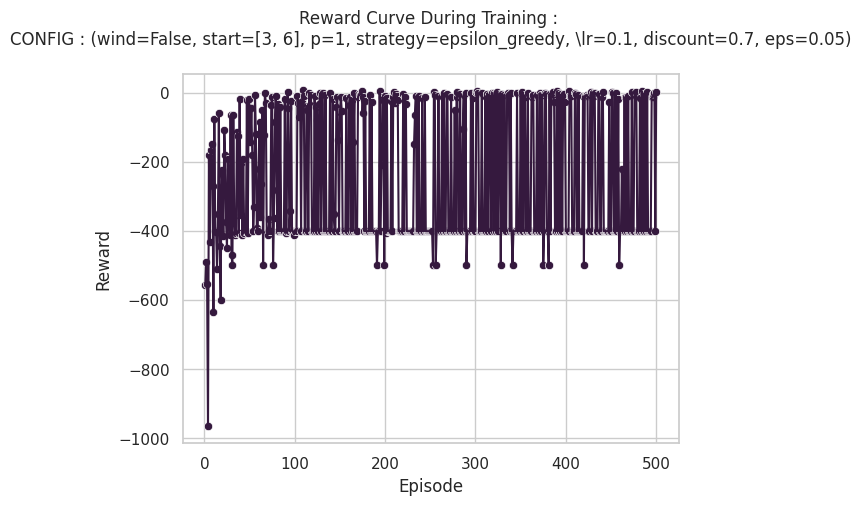

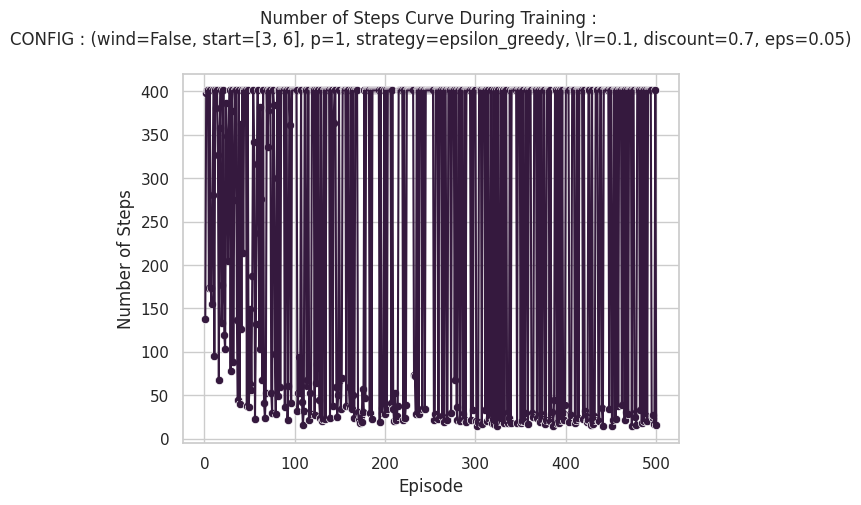

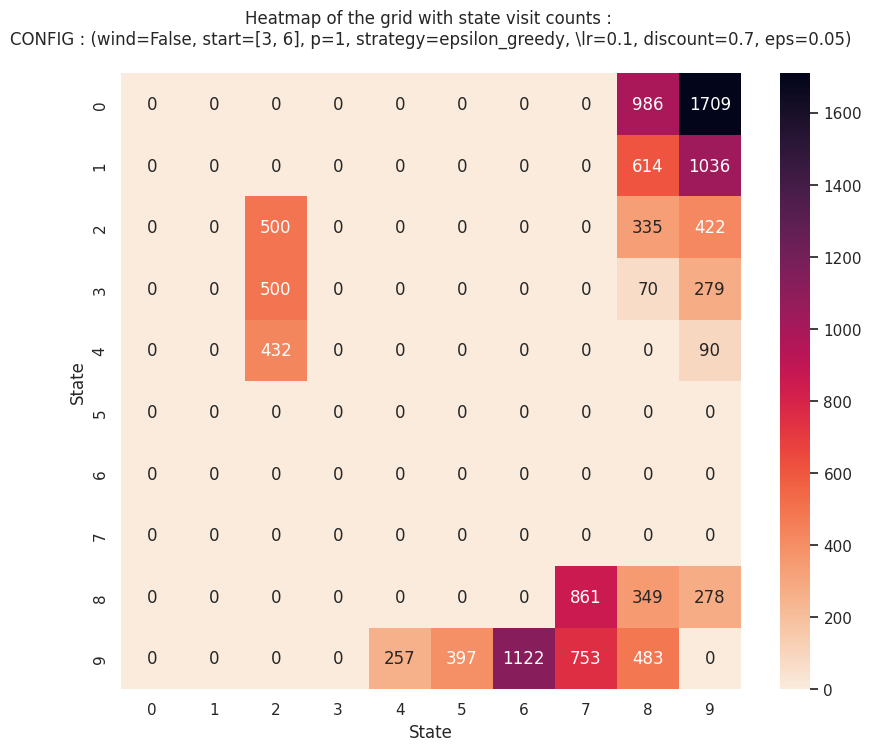

In [ ]:
Q, train_rewards, train_steps, state_visit_counts, test_rewards = val

# THIS IS THE FINAL RESULT FOR 1 CONFIGURATION IN THE HYPERPARAMETER SEARCH

test_rews, test_steps = run_episodes(env, Q, sarsa_final_run_num_episodes)
print("\n********************** FINAL RUN *************************")
print("Average Reward : {}, Average No. of Steps : {}".format(test_rews, test_steps))
print("***********************************************************\n")

config_str = "\nCONFIG : (wind={}, start={}, p=1, strategy={}, \lr={}, \
discount={}, eps={})\n".format(wind, start_state, strategy, \
                               alpha, gamma, eps_or_temp)

plot_required_graphs(Q, train_rewards, train_steps, state_visit_counts, \
                  test_rewards, sarsa_test_num_episodes, config_str)

**Hyperparameter Search on SARSA**

In [ ]:
# Hyperparameter search on SARSA

c = 0

# Just to encode/decode the configuration names
decoder = {}
sarsa_results = {}

# Loop through all configurations
for config in sarsa_cfgs:
  wind, start_state, p_value, strategy, alpha, gamma, epsilon_or_temp = config

  if(strategy == 'epsilon_greedy') :
    config_str = "\nCONFIG {} : wind={}, start={}, p={}, strategy={}, lr={}, discount={}, eps={}".format(c, wind, start_state, p_value, strategy, alpha, gamma, epsilon_or_temp)
  else :
    config_str = "\nCONFIG {} : wind={}, start={}, p={}, strategy={}, lr={}, discount={}, temp={}".format(c, wind, start_state, p_value, strategy, alpha, gamma, epsilon_or_temp)

  print(config_str)

  key = encode(config_str)
  decoder[key] = config_str

  env = create_env(start_state=start_state, wind=wind)

  val = sarsa(env=env, num_episodes=no_of_episodes, strategy=strategy, \
              eps_or_temp=eps_or_temp, alpha=alpha, gamma=gamma)

  Q, train_rewards, train_steps, state_visit_counts, test_rewards = val

  test_rews, test_steps = run_episodes(env, Q, no_of_episodes)

  print("\n*********************** RESULTS *************************")
  print("Average Reward : {}, Average No. of Steps : {}".format(test_rews, test_steps))
  print("***********************************************************\n")

  sarsa_results[key] = (test_rews, test_steps)

  c += 1


CONFIG 0 : wind=True, start=(3, 6), p=1.0, strategy=epsilon_greedy, lr=0.1, discount=1.0, eps=0.05

********************** TEST RUN ***************************
Episode: 0, Reward : -432.185, Steps : 401.0 
***********************************************************


********************** TEST RUN ***************************
Episode: 50, Reward : -396.71, Steps : 241.11 
***********************************************************


********************** TEST RUN ***************************
Episode: 100, Reward : -38.43, Steps : 18.36 
***********************************************************


********************** TEST RUN ***************************
Episode: 150, Reward : -167.56, Steps : 118.85 
***********************************************************


*********************** RESULTS *************************
Average Reward : -41.095, Average No. of Steps : 18.6
***********************************************************


CONFIG 1 : wind=True, start=(3, 6), p=1.0, strateg

In [ ]:
df1 = copy.deepcopy(sarsa_results)

In [ ]:
temp1 = pd.DataFrame(df1)
temp1.to_csv('sarsa_results')

In [ ]:
df1 = [(key, *values) for key, values in df1.items()]
df1

[('7989b9db', -41.095, 18.6),
 ('5b11f0d0', -541.72, 399.375),
 ('cb54ee90', -401.0, 401.0),
 ('cbc98b01', -828.955, 393.825),
 ('3e1d03f8', -403.005, 399.29),
 ('e4166b13', -28.16, 44.635),
 ('850b2b58', -359.22, 315.175),
 ('549f4ba7', -245.825, 254.45),
 ('84e0e841', -401.0, 401.0),
 ('53141db7', -349.95, 355.45)]

In [ ]:
df1 = list(sorted(df1, key=lambda x: -x[1]))
df1

[('e4166b13', -28.16, 44.635),
 ('7989b9db', -41.095, 18.6),
 ('549f4ba7', -245.825, 254.45),
 ('53141db7', -349.95, 355.45),
 ('850b2b58', -359.22, 315.175),
 ('cb54ee90', -401.0, 401.0),
 ('84e0e841', -401.0, 401.0),
 ('3e1d03f8', -403.005, 399.29),
 ('5b11f0d0', -541.72, 399.375),
 ('cbc98b01', -828.955, 393.825)]

In [ ]:
best_hyperparameter = decoder[df1[0][0]]
best_hyperparameter

'\nCONFIG 5 : wind=False, start=(3, 6), p=1.0, strategy=epsilon_greedy, lr=0.1, discount=0.7, eps=0.01'

In [ ]:
pattern = r'(\w+)\s*=\s*(\([^)]+\)|[^,]+)'

cfg_val = re.findall(pattern, best_hyperparameter)
cfg = dict(cfg_val)

for key, value in cfg.items():
    try:
        if(key != 'strategy') :
          value = eval(value)
    except (ValueError, SyntaxError):
        pass
    cfg[key] = value

cfg

{'wind': False,
 'start': (3, 6),
 'p': 1.0,
 'strategy': 'epsilon_greedy',
 'lr': 0.1,
 'discount': 0.7,
 'eps': 0.01}

**Running SARSA on Best Hyperparameter**

In [ ]:
# Running Q-Learning on Best Hyperparameter

start_state = cfg['start']
wind = False

strategy = cfg['strategy']
eps_or_temp = ''

if('eps' in cfg) :
  eps_or_temp = cfg['eps']
else :
  eps_or_temp = cfg['temp']

alpha = cfg['lr']
gamma = cfg['discount']


sarsa_test_num_episodes = 1000
sarsa_final_run_num_episodes = 1000

env = create_env(start_state=start_state, wind=wind)

val = sarsa(env=env, num_episodes=sarsa_test_num_episodes, strategy=strategy, \
            eps_or_temp=eps_or_temp, alpha=alpha, gamma=gamma)


********************** TEST RUN ***************************
Episode: 0, Reward : -405.74, Steps : 386.795 
***********************************************************


********************** TEST RUN ***************************
Episode: 50, Reward : -402.675, Steps : 401.0 
***********************************************************


********************** TEST RUN ***************************
Episode: 100, Reward : -335.36, Steps : 338.075 
***********************************************************


********************** TEST RUN ***************************
Episode: 150, Reward : -52.155, Steps : 69.57 
***********************************************************


********************** TEST RUN ***************************
Episode: 200, Reward : -146.64, Steps : 158.735 
***********************************************************


********************** TEST RUN ***************************
Episode: 250, Reward : -18.36, Steps : 34.36 
********************************************


********************** FINAL RUN *************************
Average Reward : -11.27, Average No. of Steps : 26.365
***********************************************************



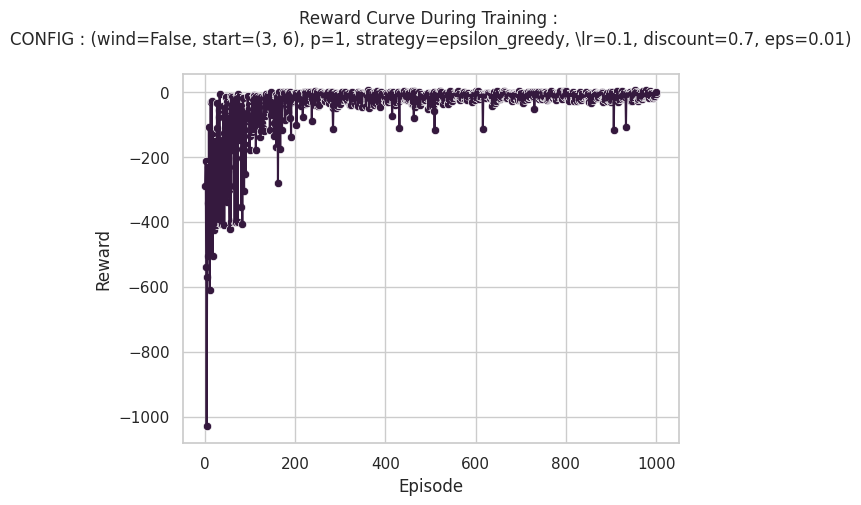

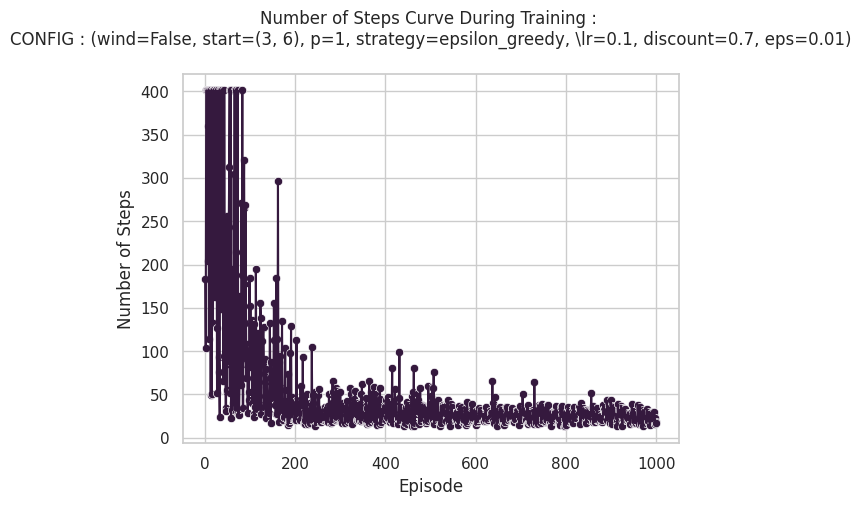

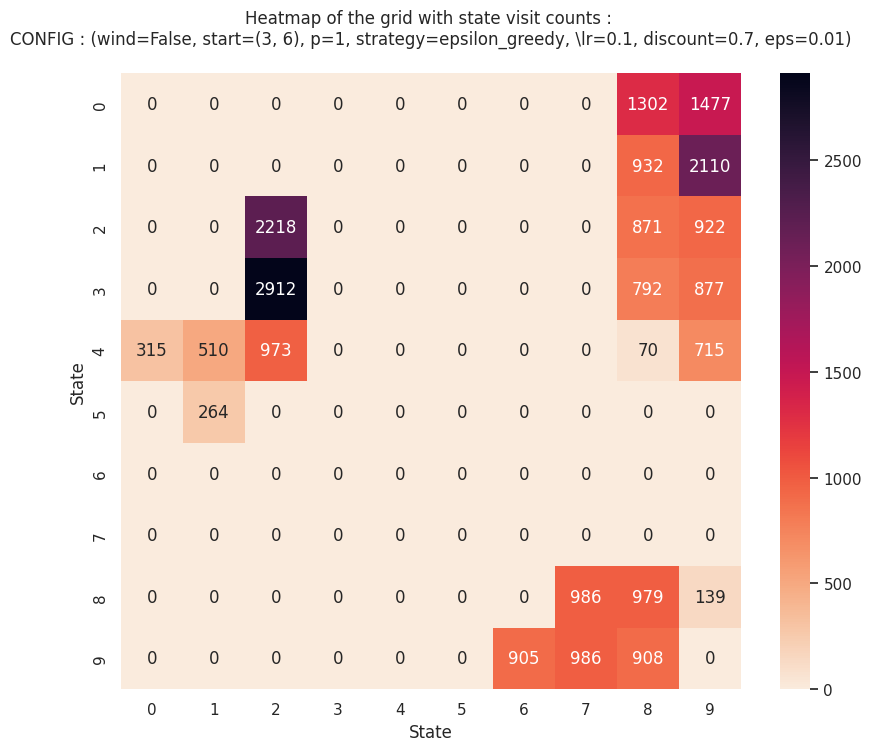

In [ ]:
Q, train_rewards, train_steps, state_visit_counts, test_rewards = val

# THIS IS THE FINAL RESULT FOR 1 CONFIGURATION IN THE HYPERPARAMETER SEARCH

test_rews, test_steps = run_episodes(env, Q, sarsa_final_run_num_episodes)
print("\n********************** FINAL RUN *************************")
print("Average Reward : {}, Average No. of Steps : {}".format(test_rews, test_steps))
print("***********************************************************\n")

config_str = "\nCONFIG : (wind={}, start={}, p=1, strategy={}, \lr={}, \
discount={}, eps={})\n".format(wind, start_state, strategy, \
                               alpha, gamma, eps_or_temp)

plot_required_graphs(Q, train_rewards, train_steps, state_visit_counts, \
                  test_rewards, sarsa_test_num_episodes, config_str)

## **Q-Learning Code**

In [ ]:
def q_learning(env, num_episodes, strategy, eps_or_temp, alpha, gamma, debug=False):

    num_actions = env.num_actions
    num_states = env.num_states
    Q = np.zeros((num_states, num_actions))

    train_rewards = []
    test_rewards = []
    total_steps = []

    # State visit count per episode
    state_visit_counts = []

    test_policy_freq = 50

    for episode in range(num_episodes):

        if(debug) :
            print("Episode : ", episode)

        state = env.reset()
        done = False
        tot_rewards = 0
        tot_steps = 0

        # loop the main body until the environment stops
        while not done:

            if(state in env.goal_states_seq) :
                if(debug) :
                      print("REACHED GOAL STATE : (steps, cumulative reward) ", \
                      tot_steps, tot_rewards, "\n")
                done = True

            if(tot_steps == max_steps_per_episode) :
                if(debug) :
                      print("FAILED TO REACH GOAL STATE : (max_steps_per_episode, \
                cumulative reward) ", max_steps_per_episode, tot_rewards, "\n")
                done = True

            # We take the action first in Q-Learning
            if(strategy == 'epsilon_greedy') :
                  action = epsilon_greedy(Q, state, eps_or_temp)
            else :
                  action = softmax(Q, state, eps_or_temp)

            # Take one step in the environment
            next_state, reward = env.step(state, action)

            Q[state][action] = \
            Q[state][action] + \
            alpha * (reward + gamma*np.max(Q[next_state]) - Q[state][action])

            # Only state is update not the action
            state = next_state

            tot_rewards += reward
            tot_steps += 1

            if done:
                train_rewards.append(tot_rewards)
                total_steps.append(tot_steps)
                state_visit_counts.append(calc_state_visit_count(Q, env.num_states))


        # Every test_policy_freq episodes, test the policy
        if (episode % test_policy_freq) == 0:
            test_rew, test_steps = run_episodes(env, Q, 1000)
            print("\n********************** TEST RUN ***************************")
            print("Episode: {}, Reward : {}, Steps : {}".format(episode, test_rew, test_steps))
            print("***********************************************************\n")
            test_rewards.append(test_rew)

    return (Q, \
            np.array(train_rewards), \
            np.array(total_steps), \
            np.array(state_visit_counts), \
            np.array(test_rewards))

**Testing Q-Learning**

In [ ]:
# Testing Q-Learning

start_state = [3,6]
wind = False

strategy = 'epsilon_greedy'
eps_or_temp = 0.05
alpha = 0.1
gamma = 0.7

q_learning_test_num_episodes = 1000
q_learning_final_run_num_episodes = 1000

env = create_env(start_state=start_state, wind=wind)

val = q_learning(env=env, num_episodes=q_learning_test_num_episodes, strategy=strategy, \
            eps_or_temp=eps_or_temp, alpha=alpha, gamma=gamma)


********************** TEST RUN ***************************
Episode: 0, Reward : -209.002, Steps : 151.077
***********************************************************


********************** TEST RUN ***************************
Episode: 50, Reward : -401.0, Steps : 401.0
***********************************************************


********************** TEST RUN ***************************
Episode: 100, Reward : -254.116, Steps : 266.828
***********************************************************


********************** TEST RUN ***************************
Episode: 150, Reward : -278.752, Steps : 284.603
***********************************************************


********************** TEST RUN ***************************
Episode: 200, Reward : -116.588, Steps : 131.676
***********************************************************


********************** TEST RUN ***************************
Episode: 250, Reward : -11.434, Steps : 28.716
********************************************


********************** FINAL RUN *************************
Average Reward : -11.716, Average No. of Steps : 28.43
***********************************************************



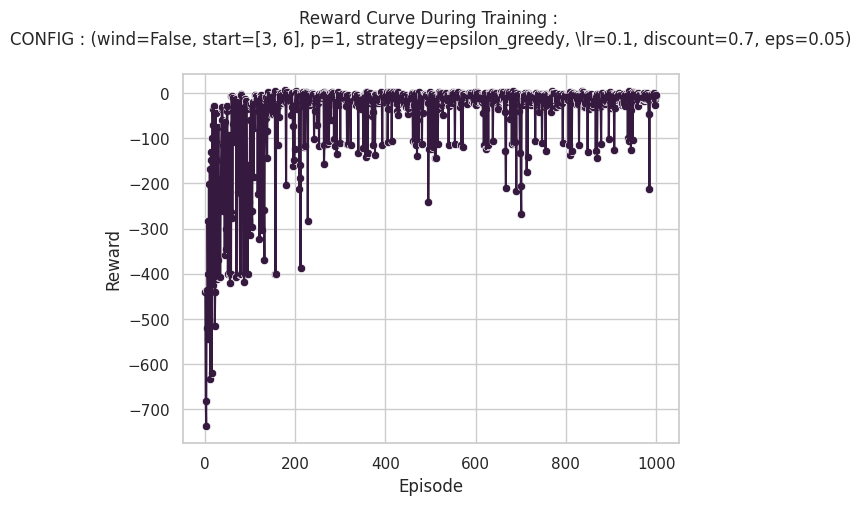

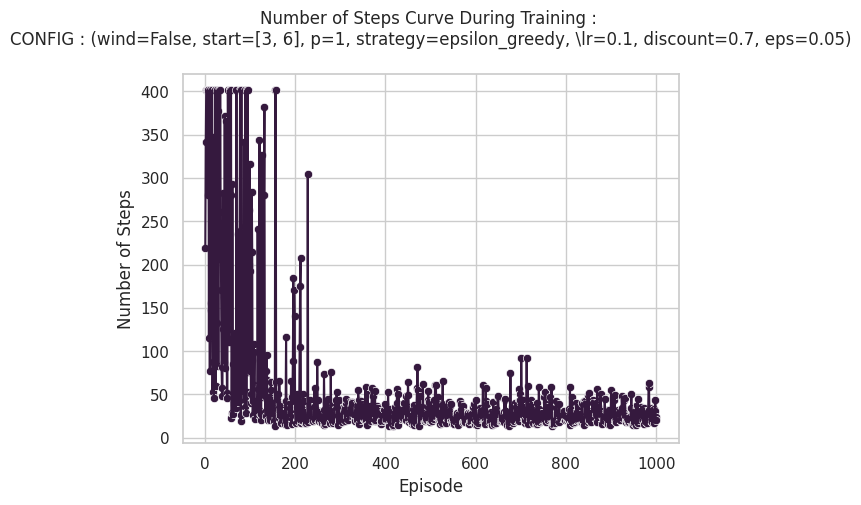

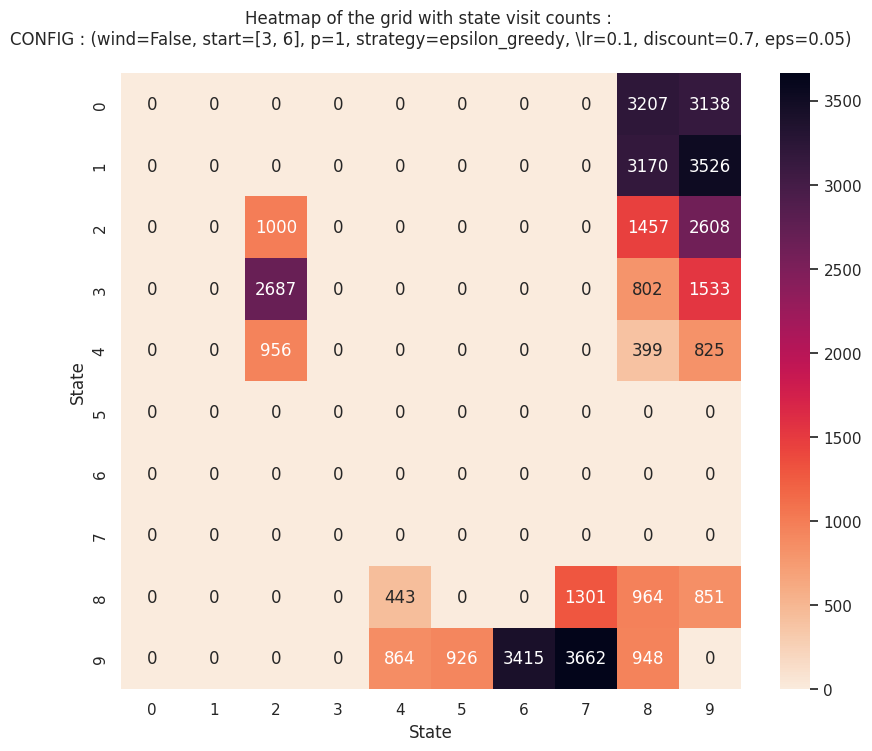

In [ ]:
Q, train_rewards, train_steps, state_visit_counts, test_rewards = val

# THIS IS THE FINAL RESULT FOR 1 CONFIGURATION IN THE HYPERPARAMETER SEARCH

test_rews, test_steps = run_episodes(env, Q, q_learning_final_run_num_episodes)
print("\n********************** FINAL RUN *************************")
print("Average Reward : {}, Average No. of Steps : {}".format(test_rews, test_steps))
print("***********************************************************\n")

config_str = "\nCONFIG : (wind={}, start={}, p=1, strategy={}, \lr={}, \
discount={}, eps={})\n".format(wind, start_state, strategy, \
                               alpha, gamma, eps_or_temp)

plot_required_graphs(Q, train_rewards, train_steps, state_visit_counts, \
                  test_rewards, q_learning_test_num_episodes, config_str)

**Hyperparameter Search on Q-Learning**

In [ ]:
# Hyperparameter search on Q-Learning

c = 0

# Just to encode/decode the configuration names
decoder = {}
q_learning_results = {}

# Loop through all configurations
for config in q_learning_cfgs:
  wind, start_state, p_value, strategy, alpha, gamma, epsilon_or_temp = config

  if(strategy == 'epsilon_greedy') :
    config_str = "\nCONFIG {} : wind={}, start={}, p={}, strategy={}, lr={}, discount={}, eps={}".format(c, wind, start_state, p_value, strategy, alpha, gamma, epsilon_or_temp)
  else :
    config_str = "\nCONFIG {} : wind={}, start={}, p={}, strategy={}, lr={}, discount={}, temp={}".format(c, wind, start_state, p_value, strategy, alpha, gamma, epsilon_or_temp)

  print(config_str)

  key = encode(config_str)
  decoder[key] = config_str

  env = create_env(start_state=start_state, wind=wind)

  val = q_learning(env=env, num_episodes=no_of_episodes, strategy=strategy, \
              eps_or_temp=eps_or_temp, alpha=alpha, gamma=gamma)

  Q, train_rewards, train_steps, state_visit_counts, test_rewards = val

  test_rews, test_steps = run_episodes(env, Q, no_of_episodes)

  print("\n*********************** RESULTS *************************")
  print("Average Reward : {}, Average No. of Steps : {}".format(test_rews, test_steps))
  print("***********************************************************\n")

  q_learning_results[key] = (test_rews, test_steps)

  c += 1


CONFIG 0 : wind=False, start=(0, 4), p=1.0, strategy=epsilon_greedy, lr=0.001, discount=0.7, eps=0.001

********************** TEST RUN ***************************
Episode: 0, Reward : -509.009, Steps : 401.0
***********************************************************


********************** TEST RUN ***************************
Episode: 50, Reward : -401.4, Steps : 401.0
***********************************************************


********************** TEST RUN ***************************
Episode: 100, Reward : -455.337, Steps : 399.968
***********************************************************


********************** TEST RUN ***************************
Episode: 150, Reward : -365.514, Steps : 337.922
***********************************************************


*********************** RESULTS *************************
Average Reward : -401.0, Average No. of Steps : 401.0
***********************************************************


CONFIG 1 : wind=False, start=(0, 4), p=1.0, st

KeyboardInterrupt: ignored

In [ ]:
df2 = copy.deepcopy(q_learning_results)

In [ ]:
temp = pd.DataFrame(df2)
temp.to_csv('q_learning')

In [ ]:
df2 = [(key, *values) for key, values in df2.items()]
df2

In [ ]:
df2 = list(sorted(df2, key=lambda x: -x[1]))
df2

In [ ]:
best_hyperparameter = decoder[df2[0][0]]
best_hyperparameter

In [ ]:
pattern = r'(\w+)\s*=\s*(\([^)]+\)|[^,]+)'

cfg_val = re.findall(pattern, best_hyperparameter)
cfg = dict(cfg_val)

for key, value in cfg.items():
    try:
        if(key != 'strategy') :
          value = eval(value)
    except (ValueError, SyntaxError):
        pass
    cfg[key] = value

cfg

In [ ]:
# Running Q-Learning on Best Hyperparameter

start_state = cfg['start']
wind = False

strategy = cfg['strategy']
eps_or_temp = ''

if('eps' in cfg) :
  eps_or_temp = cfg['eps']
else :
  eps_or_temp = cfg['temp']

alpha = cfg['lr']
gamma = cfg['discount']

q_learning_test_num_episodes = 1000
q_learning_final_run_num_episodes = 1000

env = create_env(start_state=start_state, wind=wind)

val = q_learning(env=env, num_episodes=q_learning_test_num_episodes, strategy=strategy, \
            eps_or_temp=eps_or_temp, alpha=alpha, gamma=gamma)

In [ ]:
Q, train_rewards, train_steps, state_visit_counts, test_rewards = val

# THIS IS THE FINAL RESULT FOR 1 CONFIGURATION IN THE HYPERPARAMETER SEARCH

test_rews, test_steps = run_episodes(env, Q, q_learning_final_run_num_episodes)
print("\n********************** FINAL RUN *************************")
print("Average Reward : {}, Average No. of Steps : {}".format(test_rews, test_steps))
print("***********************************************************\n")

config_str = "\nCONFIG : (wind={}, start={}, p=1, strategy={}, \lr={}, \
discount={}, eps={})\n".format(wind, start_state, strategy, \
                               alpha, gamma, eps_or_temp)

plot_required_graphs(Q, train_rewards, train_steps, state_visit_counts, \
                  test_rewards, q_learning_test_num_episodes, config_str)